### Задание по теме “Архитектуры свёрточных сетей”

##### Преподаватель: Даниил Корбут, Алексей Миронов, Иван Родин, Юлия Пономарева

#### Цель задания: изучить работу с готовыми моделями из torchvision.

#### Задание
##### Вам необходимо провести эксперименты по начальному обучению различных моделей и сравнить результаты.

    * Возьмите датасет EMNIST из torchvision
    * Обучите на нём модели: ResNet 18, VGG 16, Inception v3, DenseNet 161 (с нуля по 10 эпох)
    * Сведите результаты обучения моделей (графики лоса) в таблицу и сравните их.

Задание со звездочкой*
Выполните то же задание, используя датасет hymenoptera_data

Инструкция к выполнению задания

    Загрузите датасет, посмотрите примеры картинок в нём и проверьте наличествующие классы и их дисбаланс.
    Создайте модель текущего типа, используя интерфейс torchvision для нужного количества классов.
    Обучите модель с нуля 10 эпох.
    Фиксируйте значение функции потерь в список для последующего отображения.
    Повторите пункты 2 и 3 для всех указанных вариантов моделей.


## Архитектуры свёрточных сетей

In [2]:
#!pip install torchinfo
import torch
from torch import nn
import torchvision as tv
# from torchsummary import summary
from torchinfo import summary
import time
import gc

from matplotlib import colors, pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
import numpy as np
import pandas as pd
from itertools import accumulate

print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

1.12.1


'cpu'

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# path = "/content/drive/MyDrive/model/"
# path

In [3]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

def train(net, train_iter, test_iter, trainer, start_epochs, num_epochs, net_name):
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    loss_list = []
    for epoch in range(start_epochs, num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            gc.collect()
            torch.cuda.empty_cache()

            if i % 100 == 0:
                print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

        loss_list.append(train_l_sum/n)
        with open(path + net_name + "_loss_list.txt", "a") as file:
            file.write(" ".join([str(x) for x in loss_list]))
            file.write("\n")

        torch.save(net.state_dict(), path + f'{net_name}_epoch{epoch}.pth')
    return loss_list

In [4]:
BATCH_SIZE = 128
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('.', split='byclass', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', split='byclass', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, drop_last=True)

In [106]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

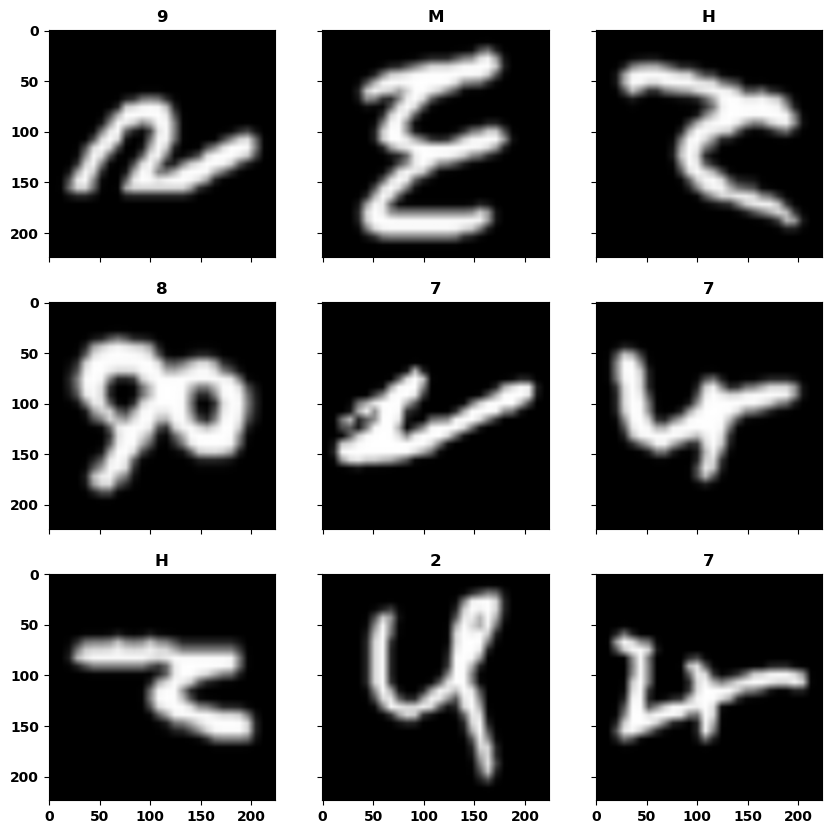

In [107]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(10, 10), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), train_dataset.classes[label].split('_')))
    imshow(im_val.data.to("cpu"), title=img_label, plt_ax=fig_x)

In [108]:
train_labels = train_dataset.train_labels
train_labels

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([35, 36,  6,  ...,  5, 11, 22])

In [109]:
train_labels_dict = {x:0 for x in train_labels.detach().numpy()}
len(train_labels_dict)

62

In [110]:
d = [i[1] for i in train_dataset]

In [111]:
d1 = np.unique(d, return_counts=True)
d1

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]),
 array([34585, 38374, 34203, 35143, 33535, 31416, 34232, 35754, 33946,
        33847,  6407,  3878, 10094,  4562,  4934,  9182,  2517,  3152,
        11946,  3762,  2468,  5076,  9002,  8237, 24983,  8347,  2605,
         5073, 20764,  9820, 12602,  4637,  4695,  2771,  4743,  2701,
        10033,  5159,  2854, 10177, 24631,  2561,  3687,  8738,  2725,
         1896,  2491, 15318,  2645, 11418,  2749,  2448,  2994, 14105,
         2699, 18262,  2830,  2910,  2697,  2822,  2365,  2725],
       dtype=int64))

<BarContainer object of 62 artists>

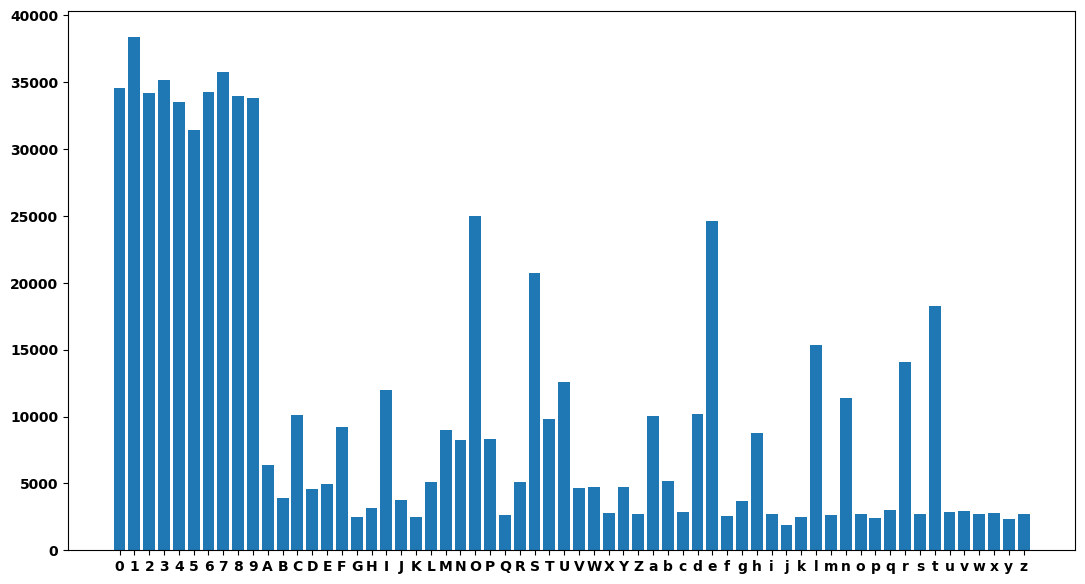

In [112]:
fig, ax = plt.subplots(figsize=(13,7))
ax.bar([k for k in train_dataset.class_to_idx.keys()], d1[1])

#### Классы несбалансированы

### ResNet

In [5]:
from itertools import accumulate
model_resnet = tv.models.resnet18(weights="IMAGENET1K_V1")

In [6]:
model_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
summary(model_resnet, (BATCH_SIZE, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 1000]               --
├─Conv2d: 1-1                            [128, 64, 112, 112]       9,408
├─BatchNorm2d: 1-2                       [128, 64, 112, 112]       128
├─ReLU: 1-3                              [128, 64, 112, 112]       --
├─MaxPool2d: 1-4                         [128, 64, 56, 56]         --
├─Sequential: 1-5                        [128, 64, 56, 56]         --
│    └─BasicBlock: 2-1                   [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-1                  [128, 64, 56, 56]         36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 56, 56]         128
│    │    └─ReLU: 3-3                    [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-4                  [128, 64, 56, 56]         36,864
│    │    └─BatchNorm2d: 3-5             [128, 64, 56, 56]         128
│    │    └─ReLU: 3-6                    [128, 64, 56, 56]         --
│

In [8]:
# Убираем требование градиента:
for param in model_resnet.parameters():
    param.requires_grad = False

In [9]:
model_resnet.fc

Linear(in_features=512, out_features=1000, bias=True)

In [10]:
model_resnet.fc = nn.Linear(in_features=512, out_features=62)

In [11]:
print("Params to learn:")
params_to_update = []
for name, param in model_resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [12]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
# checkpoint = torch.load(path + 'resnet_epoch8.pth')
# checkpoint

In [ ]:
# model_resnet.load_state_dict(checkpoint)

In [ ]:
loss_resnet = train(model_resnet, train_iter, test_iter, trainer, 10, 'resnet')
loss_resnet

### VGG16

In [99]:
model_vgg = tv.models.vgg16(weights="IMAGENET1K_V1")

In [100]:
model_vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [101]:
# Убираем требование градиента:
for param in model_vgg.parameters():
    param.requires_grad = False

In [102]:
model_vgg.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
model_vgg.classifier = nn.Sequential(
  nn.Linear(in_features=25088, out_features=4096, bias=True),
  nn.ReLU(inplace=True),
  nn.Dropout(p=0.5, inplace=False),
  nn.Linear(in_features=4096, out_features=4096, bias=True),
  nn.ReLU(inplace=True),
  nn.Dropout(p=0.5, inplace=False),
  nn.Linear(in_features=4096, out_features= 62, bias=True))

In [ ]:
summary(model_vgg,(BATCH_SIZE, 3, 224, 224))

In [ ]:
print("Params to learn:")
params_to_update = []
for name, param in model_vgg.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

In [ ]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
# checkpoint = torch.load(path + 'vgg_epoch8.pth')
# checkpoint

In [ ]:
model_vgg.load_state_dict(checkpoint)

In [ ]:
loss_vgg = train(model_vgg, train_iter, test_iter, trainer, 10, "vgg")
loss_vgg

### INCEPTION_V3

In [92]:
BATCH_SIZE_inception = 128
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((299, 299)),
    tv.transforms.CenterCrop((299, 299)),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_dataset = tv.datasets.EMNIST('.', split='byclass', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', split='byclass', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_inception, drop_last=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE_inception, drop_last=True)


In [94]:
# from torchvision.models import Weights
model_inception = tv.models.inception_v3(weights="IMAGENET1K_V1")

In [95]:
model_inception

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [96]:
# Убираем требование градиента:
for param in model_inception.parameters():
    param.requires_grad = False

In [97]:
model_inception.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [98]:
model_inception.fc = nn.Linear(in_features=2048, out_features=62, bias=True)


In [ ]:
summary(model_inception,(BATCH_SIZE_inception, 3, 299, 299))

In [ ]:
print("Params to learn:")
params_to_update = []
for name, param in model_inception.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

In [ ]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
#checkpoint = torch.load(path + 'inception_epoch8.pth')

In [ ]:
#checkpoint

In [ ]:
#model_inception.load_state_dict(checkpoint)

In [ ]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

def train_2(net, train_iter, test_iter, trainer, num_epochs, net_name):
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    loss_list = []
    for epoch in range(9, num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat, _ = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            gc.collect()
            torch.cuda.empty_cache()

            if i % 100 == 0:
                print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

        loss_list.append(train_l_sum/n)
        with open(path + net_name + "_loss_list.txt", "a") as file:
            file.write(" ".join([str(x) for x in loss_list]))
            file.write("\n")

        torch.save(net.state_dict(), path + f'{net_name}_epoch{epoch}.pth')
    return loss_list

In [ ]:
loss_inception = train_2(model_inception, train_iter, test_iter, trainer, 10, "inception")
loss_inception

### DenseNet_161

In [ ]:
model_densenet = tv.models.densenet161(weights="IMAGENET1K_V1")

In [ ]:
model_densenet

In [ ]:
# Убираем требование градиента:
for param in model_densenet.parameters():
    param.requires_grad = False

In [ ]:
model_densenet.classifier

In [ ]:
model_densenet.classifier = nn.Linear(in_features=2208, out_features=62)

In [ ]:
summary(model_densenet, (BATCH_SIZE, 3, 224, 224))

In [ ]:
print("Params to learn:")
params_to_update = []
for name, param in model_densenet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

In [ ]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
#checkpoint = torch.load(path + 'densenet_epoch9.pth')
#checkpoint

In [ ]:
model_densenet.load_state_dict(checkpoint)

In [ ]:
loss_densenet = train(model_densenet, train_iter, test_iter, trainer, 0, 10, 'densenet')
loss_densenet

### СРАВНЕНИЕ МОДЕЛЕЙ

In [13]:
df_resnet = pd.read_csv('resnet_loss_list.txt', names=['ResNet'])
df_vgg = pd.read_csv('vgg_loss_list.txt', names=['VGG16'])
df_inception = pd.read_csv('inception_loss_list.txt', names=['Inception'])
df_densenet = pd.read_csv('densenet_loss_list.txt', names=['DenseNet'])

In [14]:
pd.concat([df_resnet, df_vgg, df_inception, df_densenet], axis=1)

,ResNet,VGG16,Inception,DenseNet
0,0.769650,0.820844,0.906783,0.591638
1,0.592395,0.799230,0.660125,0.567573
2,0.568327,0.786239,0.618731,0.556201
3,0.556095,0.764825,0.607828,0.548794
4,0.552394,0.743534,0.580556,0.543816
5,0.548456,0.719322,0.577420,0.540169
6,0.541285,0.714898,0.561413,0.537358
7,0.539462,0.703695,0.549431,0.535000
8,0.536398,0.692109,0.541064,0.533275
9,0.534001,0.690027,0.540199,0.531717


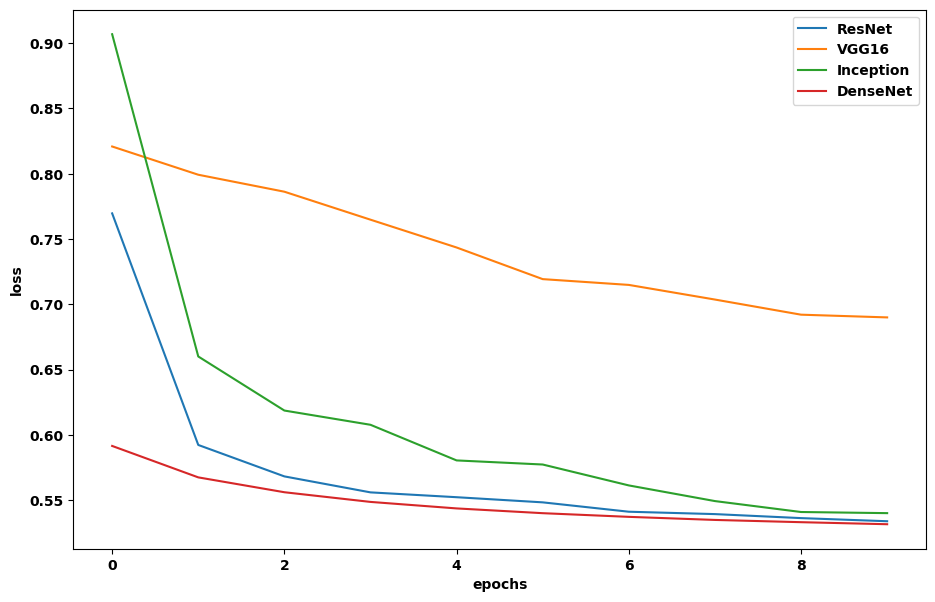

In [15]:
plt.figure(figsize=(11, 7))
plt.plot(df_resnet, label="ResNet")
plt.plot(df_vgg, label="VGG16")
plt.plot(df_inception, label="Inception")
plt.plot(df_densenet, label="DenseNet")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Выводы:
* DenseNet - лучший рез-тат;
* DenseNet, ResNet, Inception - к 10 эпохе достигли примерно одинакового рез-та.